# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and Prepare Data

In [2]:
data = "vuln_split_stats.csv"
df = pd.read_csv(data)

# Class Imbalance Analysis

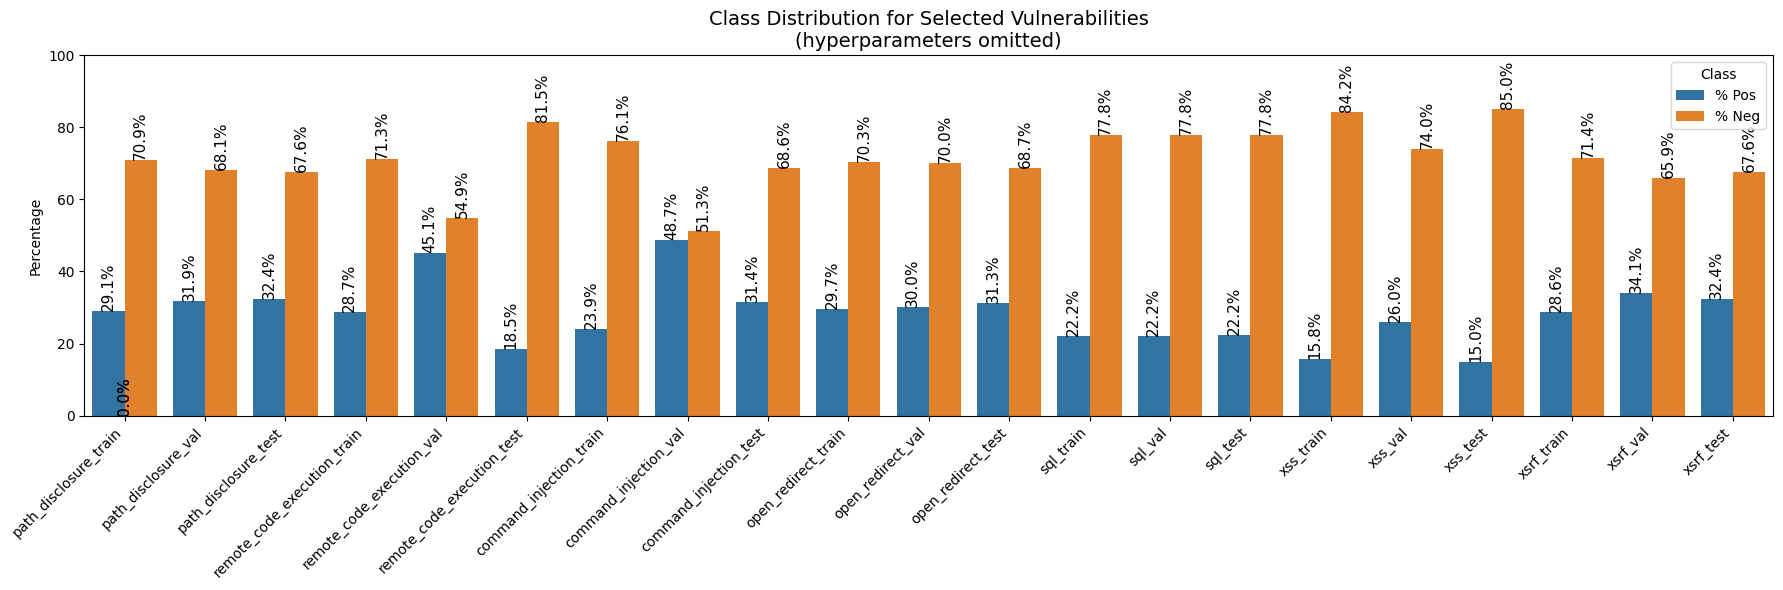

In [22]:
# 1. Compute percentages
df_plot = df.copy()

# 1. Compute class‐percentages on df_plot
df_plot["% Pos"] = 100 * df_plot["Pos"] / df_plot["Total"]
df_plot["% Neg"] = 100 - df_plot["% Pos"]

# 2. Melt into long form
df_melt = df_plot.melt(
    id_vars=["Vulnerability", "Split"],
    value_vars=["% Pos", "% Neg"],
    var_name="Class",
    value_name="Percentage",
)

# 3. Strip off the hyperparameter suffix to get the base vulnerability name
pattern = r"(.+?)(?:_n7_m128_t5(?:_ds30)?(?:\.jsonl)?)$"
df_melt["Base_Vuln"] = df_melt["Vulnerability"].str.extract(pattern)[0]

# 4. Filter to the seven you care about
selected = [
    "path_disclosure",
    "remote_code_execution",
    "command_injection",
    "open_redirect",
    "sql",
    "xss",
    "xsrf",
]
df_sel = df_melt[df_melt["Base_Vuln"].isin(selected)].copy()

# 5. Build a short label "vuln_split" for the x‐axis
df_sel["Short_Label"] = df_sel["Base_Vuln"] + "_" + df_sel["Split"]

# 6. Define the exact x‐order: for each vuln, train → val → test
splits = ["train", "val", "test"]
order = [f"{v}_{s}" for v in selected for s in splits]

# 7. Plot one wide barplot
plt.figure(figsize=(18, 6))
ax = sns.barplot(
    data=df_sel,
    x="Short_Label",
    y="Percentage",
    hue="Class",
    hue_order=["% Pos", "% Neg"],
    order=order,
    dodge=True,
)

# 8. Annotate each bar with its height (percentage)
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height):
        ax.annotate(
            f"{height:.1f}%",
            (p.get_x() + p.get_width() / 2, height),
            ha="center",
            va="bottom",
            rotation=90,
            fontsize=11
        )

# 9. Rotate & align the tick labels
plt.xticks(range(len(order)), order, rotation=45, ha="right")

# 10. Labels, title, and layout
ax.set_ylabel("Percentage")
ax.set_xlabel("")  # drop the default x‐axis label
ax.set_title(
    "Class Distribution for Selected Vulnerabilities\n(hyperparameters omitted)",
    fontsize=14,
)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()

# Dataset Size Distribution

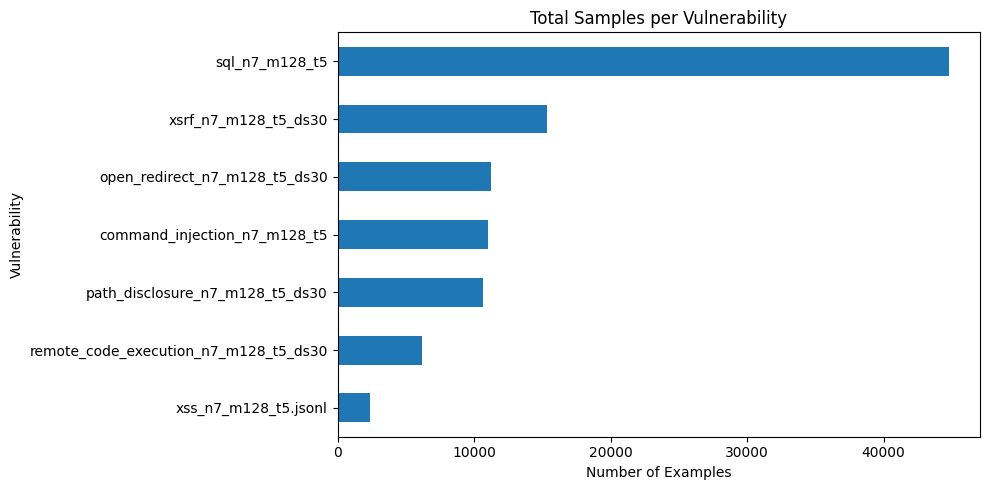

In [4]:
df_grouped = df.groupby("Vulnerability")["Total"].sum().sort_values()
df_grouped.plot(kind="barh", title="Total Samples per Vulnerability", figsize=(10, 5))
plt.xlabel("Number of Examples")
plt.tight_layout()
plt.show()


# Split Proportion Consistency

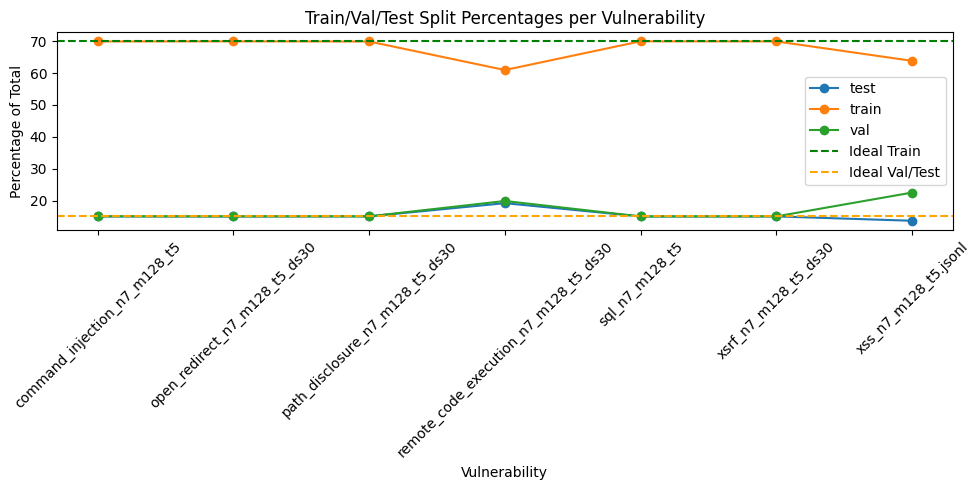

In [5]:
df["% Total"] = 100 * df["Total"] / df.groupby("Vulnerability")["Total"].transform("sum")
pivot = df.pivot(index="Vulnerability", columns="Split", values="% Total")
pivot.plot(kind="line", marker='o', figsize=(10, 5))
plt.title("Train/Val/Test Split Percentages per Vulnerability")
plt.ylabel("Percentage of Total")
plt.xticks(rotation=45)
plt.axhline(70, color='green', linestyle='--', label='Ideal Train')
plt.axhline(15, color='orange', linestyle='--', label='Ideal Val/Test')
plt.legend()
plt.tight_layout()
plt.show()


# Repo Count Per Split

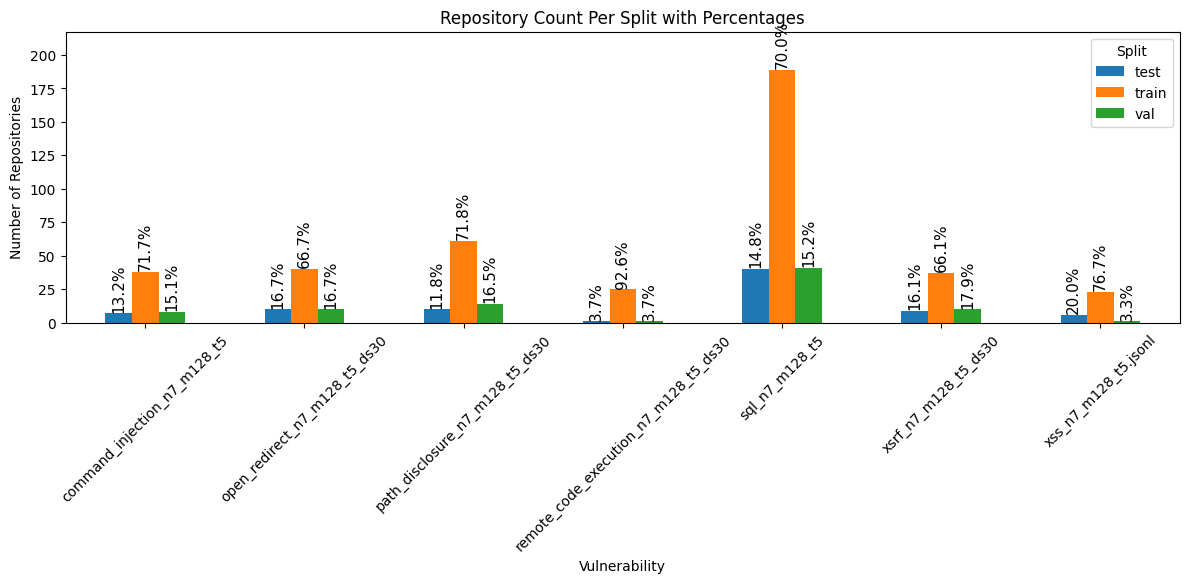

In [6]:
# Pivot to get repo count per vulnerability and split
df_repo = df.pivot(index="Vulnerability", columns="Split", values="Repos")

# Compute percentage values
df_repo_pct = df_repo.div(df_repo.sum(axis=1), axis=0) * 100

# Plot raw repo counts
ax = df_repo.plot(kind="bar", figsize=(12, 6))
plt.title("Repository Count Per Split with Percentages")
plt.ylabel("Number of Repositories")
plt.xticks(rotation=45)
plt.legend(title="Split")

# Add percentage annotations on top of bars
for container in ax.containers:
    split_name = container.get_label()
    for bar in container:
        height = bar.get_height()
        vuln = bar.get_x() + bar.get_width() / 2.0
        idx = int(round(bar.get_x()))
        split = bar.get_label()
        x = bar.get_x() + bar.get_width() / 2
        y = height
        vuln_idx = bar.get_x()
        # Find matching vulnerability and split
        for i, vuln in enumerate(df_repo.index):
            if abs(bar.get_x() - i) < 0.5:
                break
        pct = df_repo_pct.loc[vuln, split_name]
        ax.text(x, y + 1, f"{pct:.1f}%", ha="center", va="bottom", fontsize=11, rotation=90)

plt.tight_layout()
ymax = df_repo.max().max() * 1.15  # 15% padding
plt.ylim(0, ymax)
plt.show()